In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')


GPU is being used.


In [4]:
!ls /kaggle/input/animal-image-dataset-90-different-animals


 animals  'name of the animals.txt'


In [5]:
import os

# Correct dataset path: note the extra "animals" at the end.
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
if os.path.exists(dataset_path):
    classes = sorted(os.listdir(dataset_path))  # sorted for consistency
    num_classes = len(classes)

    print(f'Number of Classes: {num_classes}')
    print(f'Classes: {classes}')
else:
    print("Dataset path not found. Please check the directory structure.")

Number of Classes: 90
Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


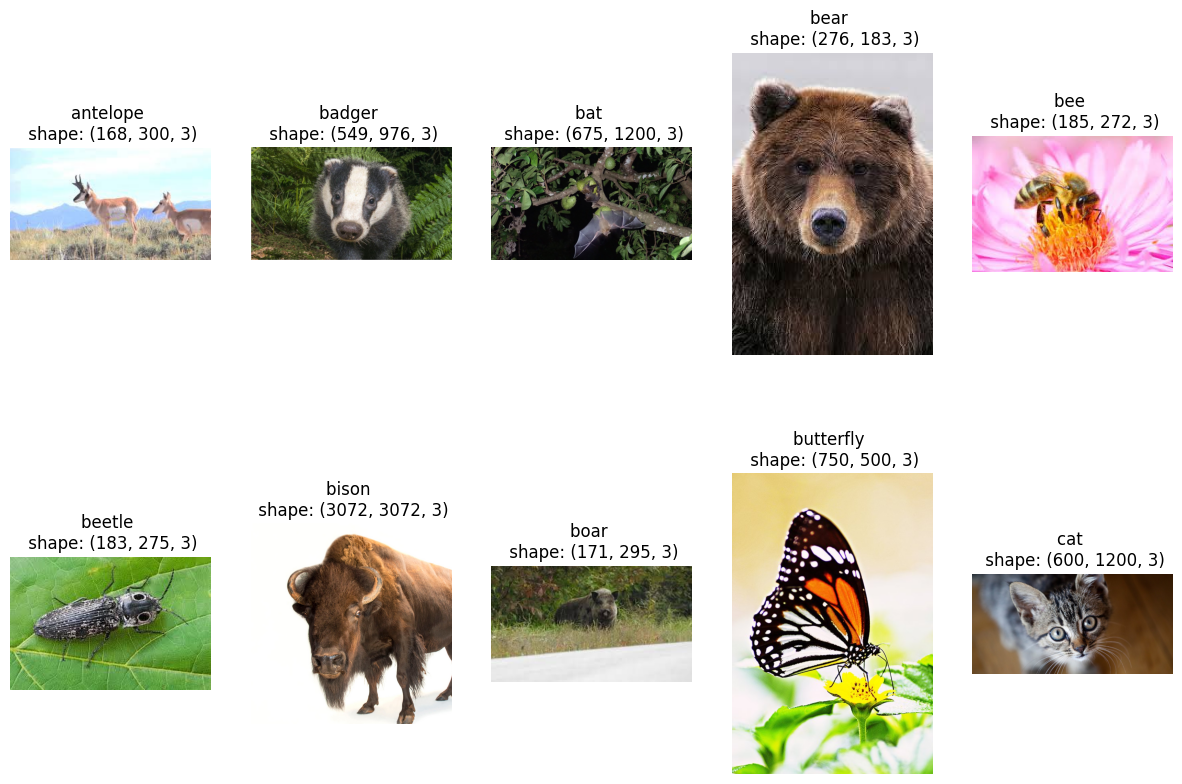

In [6]:
# Visualize some sample images form the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.show()


In [7]:
# Preprocessing the data.
# Define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # There can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [ ]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
# Extract class names
class_names = list(class_indices.keys())
print("Class Names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [8]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 968ms/step - accuracy: 0.0425 - loss: 4.5029 - val_accuracy: 0.5215 - val_loss: 3.2054
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3594 - loss: 3.5146

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3594 - loss: 3.5146 - val_accuracy: 0.5137 - val_loss: 3.1998
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 482ms/step - accuracy: 0.4300 - loss: 2.9392 - val_accuracy: 0.7031 - val_loss: 1.8781
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6094 - loss: 1.9374 - val_accuracy: 0.7051 - val_loss: 1.8526
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 534ms/step - accuracy: 0.6398 - loss: 1.7921 - val_accuracy: 0.7832 - val_loss: 1.2063
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7031 - loss: 1.3314 - val_accuracy: 0.7949 - val_loss: 1.1893
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 483ms/step - accuracy: 0.7537 - loss: 1.1406 - val_accuracy: 0.7969 - val_loss: 0.9567
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6562 - loss: 1.2161 - val_accuracy: 0.7969 - val_loss: 0.9358
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 475ms/step - accuracy: 0.7789 - loss: 0.9352 - val_accuracy: 0.8262 - val_

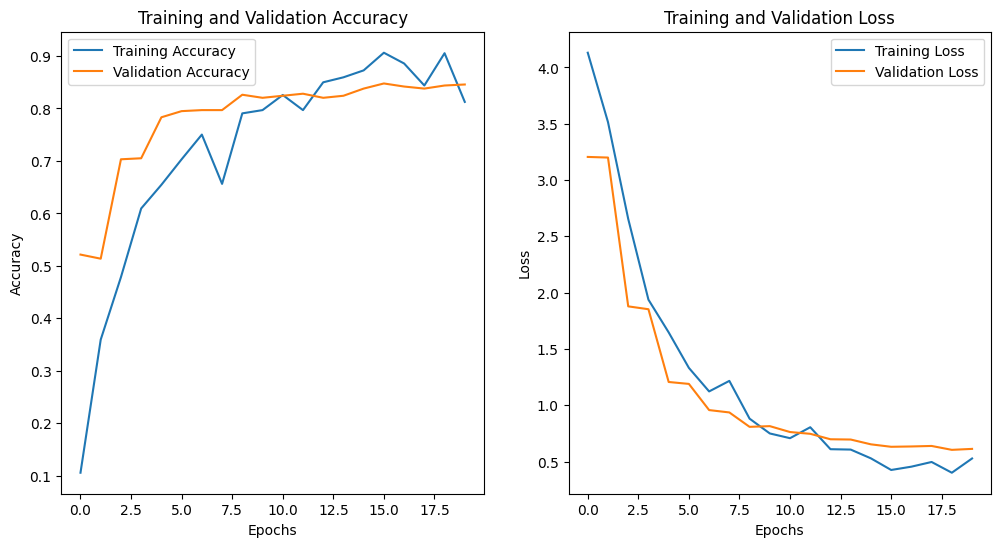

In [10]:
# Evaluate the model - plotting the training and validation acc/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 925ms/step - accuracy: 0.8510 - loss: 0.5968
Validation Loss: 0.6108630299568176
Validation Accuracy: 0.8444444537162781


In [12]:
# Save the model
model.save('MCAR.keras')

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [14]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot')

['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'

datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_names = list(generator.class_indices.keys())


Found 5400 images belonging to 90 classes.


In [19]:
class_names = list(generator.class_indices.keys())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


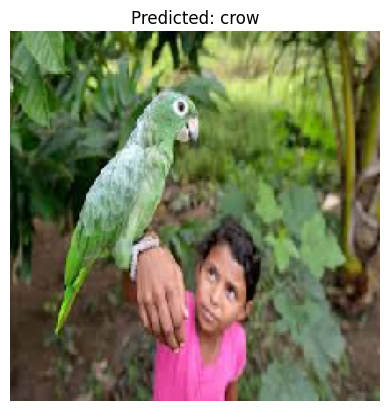

In [20]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/0100ec7408.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


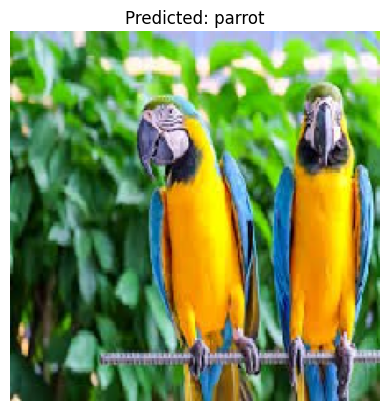

In [21]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/7a7fdb0450.jpg')
